# A Visualization study of "Netflix Movies and TV Shows" Dataset from kaggle 
## Data source : https://www.kaggle.com/datasets/shivamb/netflix-shows/data
#### Author: Wenhao C
##### And i have some idea insperition by this note: 
https://www.kaggle.com/code/joshuaswords/netflix-data-visualization/notebook

In [1]:
!pip install pycountry
!pip install wordcloud
!pip uninstall -y altair altair_viewer vega
!pip install "altair[all]" altair_viewer vega
!pip install --upgrade altair
!pip install squarify

Found existing installation: altair 5.4.1
Uninstalling altair-5.4.1:
  Successfully uninstalled altair-5.4.1
Found existing installation: altair-viewer 0.4.0
Uninstalling altair-viewer-0.4.0:
  Successfully uninstalled altair-viewer-0.4.0
Found existing installation: vega 4.0.0
Uninstalling vega-4.0.0:
  Successfully uninstalled vega-4.0.0
  Using cached altair_viewer-0.4.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached vega-4.0.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached altair-5.4.1-py3-none-any.whl.metadata (9.4 kB)
Using cached altair_viewer-0.4.0-py3-none-any.whl (844 kB)
Using cached vega-4.0.0-py3-none-any.whl (3.1 MB)
Using cached altair-5.4.1-py3-none-any.whl (658 kB)


In [1]:
import altair as alt
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import pycountry
import squarify

data= pd.read_csv("netflix_titles.csv")
alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')
print("altair version:", alt.__version__)
#alt.renderers.enable('altair_viewer')

altair version: 5.4.1


In [ ]:
help('modules')

so, let get start with.

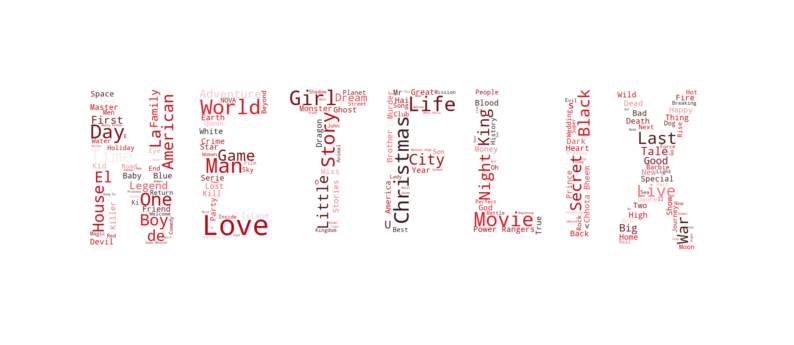

In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710', '#e50914','#f5f5f1'])
text = " ".join(data['title'].astype(str))

netflix_logo = np.array(Image.open('Netflix_Logo_RGB.png'))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap=cmap, mask=netflix_logo).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
data.iloc[100:130]

In [3]:
yearcopy = data.copy()
netflix_data = data.copy()
bar_size = 30
gap_size = 6
yeartoanlyize = 15
type_order = ['Movie', 'TV Show']
netfix_colorrange = ['#b20710', '#221f1f']
countrytoanlyize = 20

In [19]:
type_counts = data['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

type_counts['Percentage'] = (
    type_counts['Count'] / type_counts['Count'].sum() * 100
).round(1).astype(str) + '%'
typepiechart = alt.Chart(type_counts).mark_arc().encode(
    theta=alt.Theta(field='Count', type='quantitative'),
    color=alt.Color('Type:N', scale=alt.Scale(range=netfix_colorrange)),
    tooltip=['Type', 'Count', 'Percentage']
).properties(
    title='Number of Titles by Type'
)
typepiechart

alt.Chart(...)

In [8]:
grouped_data_year = yearcopy.groupby(['release_year', 'type']).size().reset_index(name='count')

total_by_year = grouped_data_year.groupby('release_year')['count'].transform('sum')
grouped_data_year['percentage'] = (grouped_data_year['count'] / total_by_year) * 100

num_years = grouped_data_year['release_year'].nunique()
chart_height = num_years * (bar_size + gap_size)
year_selection = alt.selection_point(fields=['release_year'], empty='none')
grouped_data['percentage_str'] = grouped_data['percentage'].round(2).astype(str) + '%'
chart = alt.Chart(grouped_data_year).mark_bar(size=bar_size).encode(
    x=alt.X('sum(percentage):Q', title='Percentage', axis=alt.Axis(
        labelExpr="datum.value + '%'")),  
    y=alt.Y('release_year:O', title='Year', axis=alt.Axis(labelPadding=20)),
    color=alt.Color('type:N', scale=alt.Scale(domain=type_order, range=netfix_colorrange)),
    tooltip=[alt.Tooltip('release_year:O', title='Year'),
             alt.Tooltip('type:N', title='Type'),
             alt.Tooltip('percentage:Q', title='Percentage', format='.2f')]  
).transform_calculate(
    percentage="datum.percentage"
).properties(
    title="Ratio of Movies and TV Shows by Year",
    width=600,
    height=chart_height
)
chart.show()

alt.Chart(...)

In [9]:
recent_years = sorted(yearcopy['release_year'].dropna().unique())[-yeartoanlyize:]
filtered_data = yearcopy[yearcopy['release_year'].isin(recent_years)]
filtered_data['rating'] = filtered_data['rating'].astype(str)

grouped_data = filtered_data.groupby(['release_year', 'type']).size().reset_index(name='count')
total_by_year = grouped_data.groupby('release_year')['count'].transform('sum')
grouped_data['percentage'] = (grouped_data['count'] / total_by_year) * 100

year_selection = alt.selection_single(fields=['release_year'], empty='none', name='YearSelector')
titlestr = f"Percentage of Movies and TV Shows by Year (Most Recent {yeartoanlyize} Years)"
main_chart = alt.Chart(grouped_data).mark_bar(size=30).encode(
    y=alt.Y('release_year:O', title='Year', sort=alt.SortField('release_year', order='ascending')),
    x=alt.X('percentage:Q', title='Percentage', axis=alt.Axis(format='.1f')),
    color=alt.Color('type:N', scale=alt.Scale(domain=type_order, range=netfix_colorrange)),
    tooltip=[
        alt.Tooltip('percentage:Q', format='.2f', title='Percentage'),
        alt.Tooltip('release_year:O', title='Year'),
        alt.Tooltip('type:N', title='Type')
    ]
).add_selection(
    year_selection
).properties(
    title=titlestr,
    width=500,
    height=400
)

rating_order = sorted(filtered_data['rating'].unique())

right_chart = alt.Chart(filtered_data).transform_filter(
    alt.datum.rating != ''
).transform_filter(
    alt.datum.rating != ''
).transform_aggregate(
    count='count()',
    groupby=['rating', 'type']
).mark_bar().encode(
    x=alt.X('rating:N', title='Rating', sort=rating_order),
    y=alt.Y('count:Q', title='Count'),
    color=alt.Color('type:N', scale=alt.Scale(domain=type_order, range=netfix_colorrange)),
    tooltip=[
        alt.Tooltip('rating:N', title='Rating'),
        alt.Tooltip('type:N', title='Type'),
        alt.Tooltip('count:Q', title='Count')
    ],
    opacity=alt.condition(
        year_selection,
        alt.value(1),    
        alt.value(0)    
    )
).properties(
    title="Rating Distribution by Movie/TV Show for Selected Year"
)

combined_chart = alt.hconcat(main_chart, right_chart).resolve_legend(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_view(
    strokeWidth=0  
)

combined_chart

/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_43832/2458294037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['rating'] = filtered_data['rating'].astype(str)
/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_43832/2458294037.py:9: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  year_selection = alt.selection_single(fields=['release_year'], empty='none', name='YearSelector')
/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_43832/2458294037.py:20: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.HConcatChart(...)

In [10]:

data['release_year'] = pd.to_numeric(data['release_year'], errors='coerce')

data = data.dropna(subset=['release_year'])

recent_years = sorted(data['release_year'].unique())[-yeartoanlyize:]

filtered_data = data[data['release_year'].isin(recent_years)]

grouped_data = filtered_data.groupby(['release_year', 'type']).size().reset_index(name='count')

grouped_data['release_year'] = grouped_data['release_year'].astype(int).astype(str)


year_order = sorted(grouped_data['release_year'].unique())
titlestr = f"Number of Movies and TV Shows Released Each Year (Most Recent {yeartoanlyize} 15 Years)" 

chart = alt.Chart(grouped_data).mark_bar().encode(
    x=alt.X('release_year:N', title='Release Year', sort=year_order, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('count:Q', title='Number of Titles'),
    color=alt.Color('type:N',
                    scale=alt.Scale(domain=type_order, range=netfix_colorrange),
                    legend=alt.Legend(title='Type')),
    xOffset=alt.XOffset('type:N'),
    tooltip=[
        alt.Tooltip('release_year:N', title='Release Year'),
        alt.Tooltip('type:N', title='Type'),
        alt.Tooltip('count:Q', title='Count')
    ]
).properties(
    title=titlestr,
    width=800,
    height=500
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)
# Display the chart
chart

alt.Chart(...)

In [11]:

movies = netflix_data[netflix_data['type'] == 'Movie'].copy()

movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

recent_years = sorted(movies['release_year'].dropna().unique())[-yeartoanlyize:]
movies_recent = movies[movies['release_year'].isin(recent_years)]

movies_recent = movies_recent.dropna(subset=['rating'])

movies_recent['rating'] = movies_recent['rating'].str.strip()
titlestr = f"Proportion of Ratings Over Release Years (Most Recent {yeartoanlyize} Years)"
stacked_bar = alt.Chart(movies_recent).mark_bar().encode(
    x=alt.X('release_year:O', title='Release Year', sort=recent_years),
    y=alt.Y('count()', stack='normalize', title='Proportion of Titles'),
    color=alt.Color('rating:N', title='Rating'),
    tooltip=[
        alt.Tooltip('release_year:O', title='Release Year'),
        alt.Tooltip('rating:N', title='Rating'),
        alt.Tooltip('count()', title='Number of Titles')
    ]
).properties(
    title=titlestr,
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)
stacked_bar

alt.Chart(...)

In [12]:
data['rating'] = data['rating'].astype(str)
data['type'] = data['type'].astype(str)
data['rating'] = data['rating'].replace('', 'Not Rated')
data['rating'] = data['rating'].fillna('Not Rated')

grouped_data = data.groupby(['rating', 'type']).size().reset_index(name='count')
rating_order = data['rating'].value_counts().index.tolist()
chart = alt.Chart(grouped_data).mark_bar().encode(
    x=alt.X('rating:N', title='Rating', sort=rating_order, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('count:Q', title='Number of Titles'),
    color=alt.Color('type:N',
                    scale=alt.Scale(domain=type_order,
                                    range=netfix_colorrange),
                    legend=alt.Legend(title='Type')),
    xOffset=alt.XOffset('type:N'),
    tooltip=[
        alt.Tooltip('rating:N', title='Rating'),
        alt.Tooltip('type:N', title='Type'),
        alt.Tooltip('count:Q', title='Count')
    ]
).properties(
    title='Distribution of Ratings by Type',
    width=800, 
    height=500
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)
# Display the chart
chart

alt.Chart(...)

In [ ]:
data.iloc[100:130]

In [13]:
titlestr = f"Distribution of Ratings by Release Year (Most Recent {yeartoanlyize} Years)"
bar_chart = alt.Chart(movies_recent).mark_bar().encode(
    x=alt.X(
        'rating:N',
        title='Rating',
        sort=alt.EncodingSortField(field='rating', op='count', order='descending')
    ),
    y=alt.Y('count():Q', title='Number of Titles'),
    color=alt.Color('rating:N', legend=None),
    tooltip=[
        alt.Tooltip('rating:N', title='Rating'),
        alt.Tooltip('count():Q', title='Number of Titles')
    ]
).properties(
    width=100,  
    height=100
).facet(
    column=alt.Column('release_year:N', title='Release Year', sort=recent_years),
    columns=4,     
    spacing=10,    
    title=titlestr
).configure_axis(
    labelFontSize=10,
    titleFontSize=12
).configure_title(
    fontSize=16,
    anchor='start'
)
bar_chart

alt.FacetChart(...)

In [14]:
titlestr = f"Heat Map of Ratings Over Release Years (Most Recent {yeartoanlyize} Years)"
rating_year_counts = movies_recent.groupby(['release_year', 'rating']).size().reset_index(name='Count')

rating_year_counts['release_year'] = rating_year_counts['release_year'].astype(str)

heatmap = alt.Chart(rating_year_counts).mark_rect().encode(
    x=alt.X('release_year:O', title='Release Year', sort=recent_years),
    y=alt.Y('rating:N', title='Rating'),
    color=alt.Color('Count:Q', title='Number of Titles', scale=alt.Scale(scheme='blues')),
    tooltip=[
        alt.Tooltip('release_year:O', title='Release Year'),
        alt.Tooltip('rating:N', title='Rating'),
        alt.Tooltip('Count:Q', title='Number of Titles')
    ]
).properties(
    title=titlestr,
    width=800,
    height=300
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)
# Display the chart
heatmap

alt.Chart(...)

In [15]:

netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'], errors='coerce')
netflix_data['year_added'] = netflix_data['date_added'].dt.year

# Count titles per year
year_counts = netflix_data['year_added'].value_counts().sort_index().reset_index()
year_counts.columns = ['Year Added', 'Count']
chart = alt.Chart(year_counts).mark_line(point=True).encode(
    x='Year Added:O',
    y='Count',
    tooltip=['Year Added', 'Count']
).properties(
    title='Number of Titles Added Over Time'
)
chart

alt.Chart(...)

In [16]:

netflix_data_countries = data.dropna(subset=['country']).copy()
netflix_data_countries.loc[:, 'country'] = netflix_data_countries['country'].str.split(', ')
netflix_data_countries = netflix_data_countries.explode('country')

country_counts = netflix_data_countries['country'].value_counts().head(countrytoanlyize).reset_index()
country_counts.columns = ['Country', 'Count']
titlestr = f"Top {countrytoanlyize} Countries with Most Titles"
chart = alt.Chart(country_counts).mark_bar().encode(
    x=alt.X('Country', sort='-y'),
    y='Count',
    color='Country'
).properties(
    title=titlestr
)
chart

alt.Chart(...)

In [20]:
country_count = netflix_data_countries['country'].value_counts().reset_index()
country_count.columns = ['country', 'count']

top_countries = country_count.head(countrytoanlyize).copy()
top_countries.loc[:, 'angle'] = 2 * np.pi * top_countries['count'] / top_countries['count'].sum()
top_countries.loc[:, 'percentage'] = (top_countries['count'] / top_countries['count'].sum()) * 100
titlestr = f"Top {countrytoanlyize} Countries Producing Movies/TV Shows (Pie Chart)"
pie_chart = alt.Chart(top_countries).mark_arc().encode(
    theta=alt.Theta(field="count", type="quantitative"),
    color=alt.Color(field="country", type="nominal", title="Country"),
    tooltip=[alt.Tooltip(field="country", type="nominal"), 
             alt.Tooltip(field="count", type="quantitative"), 
             alt.Tooltip(field="percentage", format=".2f", title="Percentage (%)")]
).properties(
    title=titlestr,
    width=500,
    height=500
)
# Display the chart
pie_chart.show()

alt.Chart(...)

In [22]:
top_countries

,country,count,angle,percentage
0,United States,2818,2.887007,45.948149
1,India,972,0.995802,15.848687
2,United Kingdom,419,0.429260,6.831893
3,Japan,245,0.251000,3.994782
4,South Korea,199,0.203873,3.244742
5,Canada,181,0.185432,2.951247
6,Spain,145,0.148551,2.364259
7,France,124,0.127037,2.021849
8,Mexico,110,0.112694,1.793576
9,Egypt,106,0.108596,1.728355


In [42]:

sizes = squarify.normalize_sizes(top_countries['count'], 100, 100)
rectangles = squarify.squarify(sizes, x=0, y=0, dx=100, dy=100)
rects_netflix_data = pd.DataFrame(rectangles)
rects_netflix_data['Country'] = top_countries['country']
rects_netflix_data['Count'] = top_countries['count']


rects_netflix_data['x0'] = rects_netflix_data['x']
rects_netflix_data['x1'] = rects_netflix_data['x'] + rects_netflix_data['dx']
rects_netflix_data['y0'] = rects_netflix_data['y']
rects_netflix_data['y1'] = rects_netflix_data['y'] + rects_netflix_data['dy']
rects_netflix_data['y0_inv'] = 100 - rects_netflix_data['y0']
rects_netflix_data['y1_inv'] = 100 - rects_netflix_data['y1']

rects_netflix_data['x_center'] = (rects_netflix_data['x0'] + rects_netflix_data['x1']) / 2
rects_netflix_data['y_center'] = (rects_netflix_data['y0_inv'] + rects_netflix_data['y1_inv']) / 2

color_scale = alt.Scale(domain=[rects_netflix_data['Count'].min(), rects_netflix_data['Count'].max()],
                        range=netfix_colorrange)  
titlestr = f"Top {countrytoanlyize} Producing Countries"
treemap = alt.Chart(rects_netflix_data).mark_rect().encode(
    x=alt.X('x0:Q', axis=None),
    x2='x1:Q',
    y=alt.Y('y1_inv:Q', axis=None),
    y2='y0_inv:Q',
    color=alt.Color('Count:Q', scale=color_scale, legend=None),
    tooltip=[alt.Tooltip('Country:N'), alt.Tooltip('Count:Q')]
).properties(
    width=800,
    height=600,
    title=titlestr
)
rects_netflix_data['Area'] = rects_netflix_data['dx'] * rects_netflix_data['dy']

area_threshold = rects_netflix_data['Area'].quantile(0.05)  # Filter small areas
label_netflix_data = rects_netflix_data[rects_netflix_data['Area'] >= area_threshold]

text = alt.Chart(label_netflix_data).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    fontWeight='bold',
    color='white'
).encode(
    x='x_center:Q',
    y='y_center:Q',
    text=alt.Text('Country:N')
)

final_chart = treemap + text

final_chart

alt.LayerChart(...)

In [24]:

netflix_data_genres = netflix_data.dropna(subset=['listed_in'])
netflix_data_genres['Genre'] = netflix_data_genres['listed_in'].str.split(', ')
netflix_data_genres = netflix_data_genres.explode('Genre')

# Count titles per genre
genre_counts = netflix_data_genres['Genre'].value_counts().head(10).reset_index()
genre_counts.columns = ['Genre', 'Count']
chart = alt.Chart(genre_counts).mark_bar().encode(
    x=alt.X('Genre', sort='-y'),
    y='Count',
    color='Genre'
).properties(
    title='Top 10 Genres'
)
chart

alt.Chart(...)

In [25]:
netflix_data_genres = data.dropna(subset=['listed_in']).copy()
netflix_data_genres['Genre'] = netflix_data_genres['listed_in'].str.split(', ')
netflix_data_genres = netflix_data_genres.explode('Genre')

netflix_data_genres['release_year'] = pd.to_numeric(netflix_data_genres['release_year'], errors='coerce')

netflix_data_genres = netflix_data_genres.dropna(subset=['release_year', 'Genre'])

netflix_data_genres['release_year'] = netflix_data_genres['release_year'].astype(int)

recent_years = sorted(netflix_data_genres['release_year'].unique())[-yeartoanlyize:]

netflix_data_genres_recent = netflix_data_genres[netflix_data_genres['release_year'].isin(recent_years)]

genre_counts_recent = netflix_data_genres_recent['Genre'].value_counts().head(10).reset_index()
genre_counts_recent.columns = ['Genre', 'TotalCount']

top_genres_recent = genre_counts_recent['Genre'].tolist()

netflix_data_genres_top_recent = netflix_data_genres_recent[netflix_data_genres_recent['Genre'].isin(top_genres_recent)]

genre_year_counts_recent = netflix_data_genres_top_recent.groupby(['Genre', 'release_year']).size().reset_index(name='Count')

year_order = sorted(genre_year_counts_recent['release_year'].unique())
titlestr = f"Heat Map of Top 10 Genres Over the Most Recent {yeartoanlyize} Years"
heatmap_recent = alt.Chart(genre_year_counts_recent).mark_rect().encode(
    x=alt.X('release_year:O', title='Release Year', axis=alt.Axis(labelAngle=-45), sort=year_order),
    y=alt.Y('Genre:N', title='Genre', sort=top_genres_recent),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='reds'), title='Number of Titles'),
    tooltip=[
        alt.Tooltip('Genre:N', title='Genre'),
        alt.Tooltip('release_year:O', title='Release Year'),
        alt.Tooltip('Count:Q', title='Number of Titles')
    ]
).properties(
    title=titlestr,
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)
heatmap_recent

alt.Chart(...)

In [26]:
# Extract duration numbers
netflix_data['duration_int'] = netflix_data['duration'].str.extract('(\d+)').astype(float)
netflix_data['duration_type'] = netflix_data['duration'].str.extract('(\d+)\s*(\w+)')[1]

# Filter movies and TV shows
movies = netflix_data[netflix_data['type'] == 'Movie']
tv_shows = netflix_data[netflix_data['type'] == 'TV Show']
moviechart = alt.Chart(movies).mark_bar().encode(
    x=alt.X('duration_int:Q', bin=alt.Bin(maxbins=50), title='Duration (Minutes)'),
    y='count()',
).properties(
    title='Movie Duration Distribution'
)
moviechart.show()

alt.Chart(...)

In [27]:
tvchart = alt.Chart(tv_shows).mark_bar().encode(
    x=alt.X('duration_int:Q', bin=alt.Bin(maxbins=15), title='Number of Seasons'),
    y='count()',
).properties(
    title='TV Show Seasons Distribution'
)

tvchart

alt.Chart(...)

In [28]:
# Split directors and explode the DataFrame
netflix_data_directors = netflix_data.dropna(subset=['director'])
netflix_data_directors['Director'] = netflix_data_directors['director'].str.split(', ')
netflix_data_directors = netflix_data_directors.explode('Director')

# Count titles per director
director_counts = netflix_data_directors['Director'].value_counts().head(10).reset_index()
director_counts.columns = ['Director', 'Count']
chart = alt.Chart(director_counts).mark_bar().encode(
    x=alt.X('Director', sort='-y'),
    y='Count',
    color='Director'
).properties(
    title='Top 10 Directors with Most Titles'
)
chart

/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_43832/1720728510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_data_directors['Director'] = netflix_data_directors['director'].str.split(', ')


alt.Chart(...)

In [32]:
from itertools import product

netflix_data['date_added'] = pd.to_datetime(netflix_data['date_added'], errors='coerce')
netflix_data_date = netflix_data.dropna(subset=['date_added']).copy()
netflix_data_date['Year'] = netflix_data_date['date_added'].dt.year
netflix_data_date['Month'] = netflix_data_date['date_added'].dt.month_name()

netflix_data_recent = netflix_data_date[netflix_data_date['Year'].isin(recent_years)]

month_year_counts = netflix_data_recent.groupby(['Year', 'Month']).size().reset_index(name='Count')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
years = month_year_counts['Year'].unique()
all_combinations = pd.DataFrame(list(product(years, month_order)), columns=['Year', 'Month'])

month_year_counts_full = pd.merge(all_combinations, month_year_counts, on=['Year', 'Month'], how='left')
month_year_counts_full['Count'] = month_year_counts_full['Count'].fillna(0)
titlestr = f"Heat Map of Number of Titles by Month and Year (Most Recent {yeartoanlyize} Years)"
heatmap_month_year = alt.Chart(month_year_counts_full).mark_rect().encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Month:N', title='Month', sort=month_order),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='reds'), title='Number of Titles'),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('Month:N', title='Month'),
        alt.Tooltip('Count:Q', title='Number of Titles')
    ]
).properties(
    title=titlestr,
    width=800,
    height=400
)
# Display the heat map
heatmap_month_year

alt.Chart(...)

In [33]:
movies = netflix_data[netflix_data['type'] == 'Movie'].copy().dropna()

movies['duration_min'] = movies['duration'].str.extract('(\d+)').astype(int)

histogram = alt.Chart(movies).mark_bar().encode(
    alt.X('duration_min:Q', bin=alt.Bin(maxbins=30), title='Duration (Minutes)'),
    alt.Y('count()', title='Number of Movies'),
    tooltip=[
        alt.Tooltip('duration_min:Q', title='Duration (Minutes)'),
        alt.Tooltip('count()', title='Number of Movies')
    ]
).properties(
    title='Distribution of Movie Durations',
    width=600,
    height=400
)
histogram

alt.Chart(...)

In [59]:
    movies = movies.dropna(subset=['release_year'])
movies['release_year'] = movies['release_year'].astype(int)

# Select recent years if desired
recent_years = sorted(movies['release_year'].unique())[-15:]
movies_recent = movies[movies['release_year'].isin(recent_years)]
# Create box plot
boxplot = alt.Chart(movies_recent).mark_boxplot().encode(
    x=alt.X('release_year:O', title='Release Year'),
    y=alt.Y('duration_min:Q', title='Duration (Minutes)'),
    tooltip=[
        alt.Tooltip('release_year:O', title='Release Year'),
        alt.Tooltip('duration_min:Q', title='Duration (Minutes)')
    ]
).properties(
    title='Movie Durations by Release Year (Most Recent 15 Years)',
    width=800,
    height=400
)
boxplot

alt.Chart(...)

In [61]:
tv_shows = netflix_data[netflix_data['type'] == 'TV Show'].copy()


tv_shows['seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(int)

seasons_count = tv_shows['seasons'].value_counts().reset_index()
seasons_count.columns = ['seasons', 'count']

seasons_count = seasons_count.sort_values('seasons')

bar_chart = alt.Chart(seasons_count).mark_bar().encode(
    x=alt.X('seasons:O', title='Number of Seasons'),
    y=alt.Y('count:Q', title='Number of TV Shows'),
    tooltip=[
        alt.Tooltip('seasons:O', title='Number of Seasons'),
        alt.Tooltip('count:Q', title='Number of TV Shows')
    ]
).properties(
    title='Number of TV Shows by Season Count',
    width=600,
    height=400
)
bar_chart

alt.Chart(...)

In [65]:
movies_genres = movies.dropna(subset=['listed_in']).copy()
movies_genres['Genre'] = movies_genres['listed_in'].str.split(', ')
movies_genres = movies_genres.explode('Genre')
movies_genres['Genre'] = movies_genres['Genre'].str.strip()


genre_duration = movies_genres.groupby('Genre')['duration_min'].mean().reset_index()

genre_bar = alt.Chart(genre_duration).mark_bar().encode(
    x=alt.X('duration_min:Q', title='Average Duration (Minutes)'),
    y=alt.Y('Genre:N', sort='-x'),
    tooltip=[
        alt.Tooltip('Genre:N', title='Genre'),
        alt.Tooltip('duration_min:Q', title='Average Duration (Minutes)')
    ]
).properties(
    title='Average Movie Duration by Genre',
    width=600,
    height=400
)
genre_bar

alt.Chart(...)

In [35]:
tv_shows['genre'] = tv_shows['listed_in'].str.split(', ')
tv_shows = tv_shows.explode('genre')

tv_shows['seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)

grouped_tv_shows = tv_shows.groupby(['genre']).agg(
    avg_seasons=('seasons', 'mean'),
    count_series=('seasons', 'size')
).reset_index()

bar_chart = alt.Chart(grouped_tv_shows).mark_bar().encode(
    x=alt.X('genre:N', sort='-y', title='Genre'),
    y=alt.Y('avg_seasons:Q', title='Average Number of Seasons'),
    color=alt.Color('avg_seasons:Q', scale=alt.Scale(scheme='reds'), legend=None),
    tooltip=[alt.Tooltip('genre:N', title='Genre'),
             alt.Tooltip('avg_seasons:Q', title='Average Number of Seasons'),
             alt.Tooltip('count_series:Q', title='Number of TV Shows')]
).properties(
    title='Average Number of Seasons by Genre for TV Shows',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)


bar_chart

alt.Chart(...)

In [39]:
tv_shows['seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)

grouped_by_seasons = tv_shows.groupby('seasons').size().reset_index(name='count')

bar_chart_seasons = alt.Chart(grouped_by_seasons).mark_bar().encode(
    x=alt.X('seasons:O', title='Number of Seasons'),
    y=alt.Y('count:Q', title='Number of TV Shows'),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='reds'), legend=None),
    tooltip=[alt.Tooltip('seasons:O', title='Number of Seasons'),
             alt.Tooltip('count:Q', title='Number of TV Shows')]
).properties(
    title='Number of TV Shows by Number of Seasons',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)

bar_chart_seasons.show()

curve_chart = alt.Chart(grouped_by_seasons).mark_line(interpolate='monotone').encode(
    x=alt.X('seasons:Q', title='Number of Seasons'),
    y=alt.Y('count:Q', title='Number of TV Shows'),
    tooltip=[alt.Tooltip('seasons:Q', title='Number of Seasons'),
             alt.Tooltip('count:Q', title='Number of TV Shows')]
).properties(
    title='Number of TV Shows by Number of Seasons (Curve)',
    width=800,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16,
    anchor='start'
)

# Display the curve chart
curve_chart.show()

alt.Chart(...)

alt.Chart(...)

In [69]:
avg_duration_movie = movies.groupby('release_year')['duration_min'].mean().reset_index()


line_movie = alt.Chart(avg_duration_movie).mark_line().encode(
    x=alt.X('release_year:Q', title='Release Year'),
    y=alt.Y('duration_min:Q', title='Average Duration (Minutes)'),
    tooltip=[
        alt.Tooltip('release_year:Q', title='Release Year'),
        alt.Tooltip('duration_min:Q', title='Average Duration (Minutes)')
    ]
).properties(
    title='Average Movie Duration Over Time',
    width=800,
    height=400
)
line_movie

alt.Chart(...)

In [70]:
avg_seasons_tv = tv_shows.groupby('release_year')['seasons'].mean().reset_index()


line_tv = alt.Chart(avg_seasons_tv).mark_line(color='green').encode(
    x=alt.X('release_year:Q', title='Release Year'),
    y=alt.Y('seasons:Q', title='Average Number of Seasons'),
    tooltip=[
        alt.Tooltip('release_year:Q', title='Release Year'),
        alt.Tooltip('seasons:Q', title='Average Number of Seasons')
    ]
).properties(
    title='Average Number of Seasons for TV Shows Over Time',
    width=800,
    height=400
)
line_tv

alt.Chart(...)

In [71]:
avg_duration_movie['type'] = 'Movie'
avg_duration_movie = avg_duration_movie.rename(columns={'duration_min': 'value'})

avg_seasons_tv['type'] = 'TV Show'
avg_seasons_tv = avg_seasons_tv.rename(columns={'seasons': 'value'})
# Combine DataFrames
avg_combined = pd.concat([avg_duration_movie, avg_seasons_tv])
# Create line chart
line_combined = alt.Chart(avg_combined).mark_line().encode(
    x=alt.X('release_year:Q', title='Release Year'),
    y=alt.Y('value:Q', title='Average Duration (Minutes) / Number of Seasons'),
    color=alt.Color('type:N', title='Type'),
    tooltip=[
        alt.Tooltip('release_year:Q', title='Release Year'),
        alt.Tooltip('type:N', title='Type'),
        alt.Tooltip('value:Q', title='Average Value')
    ]
).properties(
    title='Average Movie Duration and TV Show Seasons Over Time',
    width=800,
    height=400
)
line_combined

alt.Chart(...)

In [74]:
movies_recent = movies[movies['release_year'].isin(recent_years)]

# Create faceted KDE plot
kde_facet_movie = alt.Chart(movies_recent).transform_density(
    'duration_min',
    as_=['duration_min', 'density'],
    groupby=['release_year']
).mark_area().encode(
    x=alt.X('duration_min:Q', title='Duration (Minutes)'),
    y=alt.Y('density:Q', title='Density'),
    facet=alt.Facet('release_year:N', columns=3, title='Release Year'),
    tooltip=[
        alt.Tooltip('duration_min:Q', title='Duration (Minutes)'),
        alt.Tooltip('density:Q', title='Density')
    ]
).properties(
    title='Movie Duration Distributions by Release Year',
    width=200,
    height=100
).configure_title(
    fontSize=16,
    anchor='start'
)
kde_facet_movie

alt.Chart(...)